In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

from data_cube import DataCube
from ssm import SSM
from similarity_network_fusion import SNF

In [2]:
from tslearn.metrics import dtw, dtw_path

In [3]:
dc = DataCube(
    subjects="all",
    gestures=["1", "2", "3", "4"],
    channels=["2", "4", "6", "8"],
    data_grp="parsed"
)
dc.load_data()
dc.rms_smooth(300, 20)
dc.normalize_modalities(smooth=True)

---

In [4]:
def pass_synergist_channels(gnum, array):
    """
    pass synergist only channels for each gesture
    gnum - gesture number (i.e. 1, 2, 3, or 4)
    array - entire array of all channels and time index
    """
    synrgsts = {"1":[0, 1, 4], # channels 2 & 8; 0 is tidx
                "2":[0, 2, 3], # channels 4 & 6; 0 is tidx
                "3":[0, 1, 2], # channels 4 & 2; 0 is tidx
                "4":[0, 3, 4]} # channels 6 & 8; 0 is tidx
    synergist_array = np.c_[array[:, synrgsts[gnum][0]],
                            array[:, synrgsts[gnum][1]],
                            array[:, synrgsts[gnum][2]]]
    return synergist_array

---

In [5]:
def perform_fusions(k):
    
    dict_synerg = {}
    for s, gdict in dc.data_set_smooth.items():
        dict_synerg[s] = {}
        for g, a in gdict.items():
            snf = SNF(pass_synergist_channels(g[0], a), k=k)
            # calculate graph weights to find knn
            snf.calc_weights()
            snf.normalize_weights()
            # generate and normalize knn graphs
            snf.calc_knn_weights()
            snf.normalize_knn_weights()
            # fuse graphs
            snf.network_fusion(eta=0.2, iters=50)
            # save template to dict
            dict_synerg[s][g] = snf.fused_similarity_template
            
    return dict_synerg

---

In [6]:
def perform_pca():
    decomp_syn = {}

    for s, gdict in dict_synerg.items():
        decomp_syn[s] = {}
        for g, a in gdict.items():
            evals, evecs = la.eig(a)
            evals = evals.real
            sort_idx = np.argsort(-evals)
            evals = evals[sort_idx]
            evecs = evecs[:, sort_idx]
            # do PCA
            res = a @ evecs[:, 0]
            res = scale(res.real)
            decomp_syn[s][g] = res
            
    return decomp_syn

---

In [7]:
k = 0.1
ct = 0

acc = np.zeros(18)

while k <= 1:
    print(k)
    pred_labs = []
    # perform fusion and decomposition
    dict_synerg = perform_fusions(k)
    decomp_syn = perform_pca()
    # organize vectors and true labels
    true_lab = []
    gest_vect = []
    for s, gdict in decomp_syn.items():
        for g, a in gdict.items():
            true_lab.append(int(g[0]))
            gest_vect.append(a)
    # compare vectors and make predictions
    for n, g1 in enumerate(gest_vect):
        dtw_diffs = np.zeros(len(gest_vect))
        for m, g2 in enumerate(gest_vect):
            dtw_diffs[m] = dtw(g1, g2)
        # 2nd closest vector is predicted label; 1st closest is self
        dist_idx = np.argsort(dtw_diffs)
        pred = true_lab[dist_idx[1]]
        pred_labs.append(pred)
        
    acc[ct] = np.mean(true_lab == pred_labs)
        
    k += 0.05
    ct += 1

0.1
0.15000000000000002
0.2
0.25
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.6
0.65
0.7000000000000001
0.7500000000000001
0.8000000000000002
0.8500000000000002
0.9000000000000002
0.9500000000000003


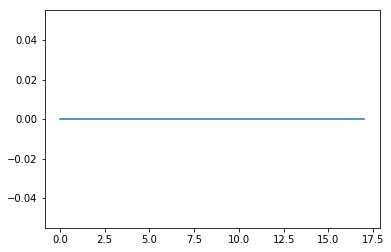

In [8]:
plt.plot(range(len(acc)), acc)